# **CIS 520: Machine Learning, Fall 2020**
# **Week 5, Worksheet 3**
## Convolutional Neural Networks


- **Content Creators:** Yide Zhao, Mihir Parmar
- **Content Reviewers:**  Shaozhe Lyu, Michael Zhou, Tejas Srivastava




Learning Objectives:
* How to build a convolutional neural net in PyTorch
* Understand window size, stride, padding for convolutional layer
* Understand dropout layer and how it could avoid overfitting


In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
from matplotlib import pyplot as plt

# Loading the data

In [2]:
trainset = datasets.MNIST('./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
testset = datasets.MNIST('./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

# Visualize the dataset

The label is:  tensor(4)
The label is:  tensor(3)
The label is:  tensor(2)


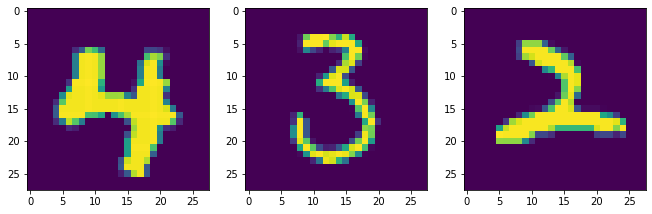

In [4]:
images, labels = iter(trainloader).next()
fig=plt.figure(figsize=(15, 10))
for i in range(1, 4):
    fig.add_subplot(1, 4, i)
    plt.imshow(images[i].numpy().squeeze())
    print('The label is: ', labels[i])
plt.show()

Remember the dimension of the image is 28 * 28, which will be very useful in designing the convolutional layer.

In [5]:
print(images.shape)

torch.Size([16, 1, 28, 28])


# Convolutional Neural Networks (CNN)

The goal is to build a model that successfully classifies hand-written digits. 

The CNN model takes an image as input and outputs what number is this hand-written digit. To do this, we will use a **convolutional neural network (CNN)**, which is a particular kind of neural network commonly used for computer vision. CNNs are just like the normal feed-forward networks from the Neural Network Worksheet, except that they have some extra layers like convolutional layers, max-pooling layer, and so on.

Now, we'll walk through the different types of layers typically present in a CNN.

## Key Component: Fully connected layers

In a fully connected layer, each unit computes a weighted sum over all the input units and applies a non-linear function to this weighted sum. You have used such layers many times already in the previous worksheet. As you have already seen, these are implemented in PyTorch using the `nn.Linear` class. Usually, you will use the fully connected layers at the end of the model pipeline. The following is similar to the one you have seen from the Neural Network Worksheet.

In [6]:
class CNN1(nn.Module):
  def __init__(self, input, hiddensize = 100):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(input, hiddensize)
    self.out_layer = nn.Linear(hiddensize, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.in_layer(x))
    x = self.out_layer(x)
    return x

## Key Component: Convolutional layers

In a convolutional layer, each unit computes a weighted sum over a two-dimensional $K \times K$ patch of inputs. The units are arranged in **channels** (see figure below), whereby units in the same channel compute the same weighted sum over different parts of the input, using the weights of that channel's **convolutional filter (or kernel)**. The output of a convolutional layer is thus a three-dimensional tensor of shape $C^{out} \times H \times W$, where $C^{out}$ is the number of channels (i.e. the number of convolutional filters/kernels), and $H$ and $W$ are the height and width of the input.

  <p align="center">
    <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/convnet.png?raw=true" width="350" />
  </p>

Such layers can be implemented in Python using the PyTorch class `nn.Conv2d`, which takes the same arguments as `nn.Conv1d` (documentation [here](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html)).
  




### Padding
Padding: adding extra pixels of filler around the boundary of our input image, thus increasing the effective size of the image. Typically, we set the values of the extra pixels to zero. In the following figure, we pad a  3×3  input, increasing its size to  5×5 . The corresponding output then increases to a  4×4  matrix. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation:  0×0+0×1+0×2+0×3=0.
<p align="center">
<img src="https://github.com/yidezhao/cis520/blob/master/padding.png?raw=true" width="600" />
<p/>

### Stride
Stride: Normally, we default to sliding one element at a time. However, sometimes, either for computational efficiency or because we wish to downsample, we move our window more than one element at a time, skipping the intermediate locations. The following figure shows a two-dimensional cross-correlation operation with a stride of 3 vertically and 2 horizontally. The shaded portions are the output elements as well as the input and kernel tensor elements used for the output computation:  0×0+0×1+1×2+2×3=8 ,  0×0+6×1+0×2+0×3=6 . We can see that when the second element of the first column is outputted, the convolution window slides down three rows. The convolution window slides two columns to the right when the second element of the first row is outputted. When the convolution window continues to slide two columns to the right on the input, there is no output because the input element cannot fill the window (unless we add another column of padding).
<p align="center">
<img src="https://github.com/yidezhao/cis520/blob/master/stride.png?raw=true" width="600" />
<p/>

## Example 1: One convolutional layer CNN
The following is an example of a one convolutional layer CNN. For the convolutional layer, the kernal size is 3*3, the stride is 1 and padding is 1.

In [7]:
class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.linear_1 = torch.nn.Linear(28 * 28 * 16, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = x.reshape(x.size(0), -1) # Flatten the image from [16, 16, 28, 28] to [16, 16*28*28] 
        x = self.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

## Exercise 1: 
1. Implement a CNN in the following code snippet. The CNN has 2 convolutional layers. The first layer has 1 in_channels, 32 out_channels, kernel size 3, 1 stride and 1 padding. The second layer has 32 in_channels, 64 out_channels. Choose your own kernel size, stride, and padding. 
*HINT: make sure your dimensions fit and flatten the image before passing into dense layer.*

In [8]:
class CNN3(torch.nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.linear_1 = torch.nn.Linear(64*28*28, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.relu = torch.nn.ReLU()
        

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x
        pass

## Key Component: Max pooling layers

In a max pooling layer, each unit computes the maximum over a small two-dimensional $K^{pool} \times K^{pool}$ patch of inputs. Given a multi-channel input of dimensions $C \times H \times W$, the output of a max pooling layer has dimensions $C \times H^{out} \times W^{out}$, where:
\begin{align}
  H^{out} &= \left\lfloor \frac{H}{K^{pool}} \right\rfloor\\
  W^{out} &= \left\lfloor \frac{W}{K^{pool}} \right\rfloor
\end{align}
$\lfloor\cdot\rfloor$ denotes rounding down to the nearest integer below (i.e. floor division `//` in Python).

  Max pooling layers can be implemented with the PyTorch `nn.MaxPool2d` class, which takes as a single argument the size $K^{pool}$ of the pooling patch. Note that we need to calculate the dimensions of its output in order to set the dimensions of the subsequent fully connected layer.

In [9]:
class CNN4(torch.nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(14 * 14 * 16, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1) 
        x = self.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

## Exercise 2: 
1. Implement a CNN in the following code snippet. The CNN should have 2 convolutional layers, each followed by a max pooling layer. The first layer has been already implemented for you. The second convolutional layer has 32 in_channels, 64 out_channels. Choose your own kernel size, stride, and padding. Add a max pooling layer after the second convolutional layer. 
*HINT: make sure your dimensions fit and flatten the image before passing into dense layer.*

In [ ]:
class CNN5(torch.nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = torch.nn.ReLU()
        # TODO: add the second convolutional layer, maxpooling layer and dense layers
        

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool2d(x)
        # TODO
        pass

### Solution

In [10]:
class CNN5(torch.nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = torch.nn.ReLU()
        # TODO: add the second convolutional layer, maxpooling layer and dense layers
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(64*7*7, 128)
        self.linear_2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        # TODO
        x = self.relu(self.conv_1(x))
        x = self.max_pool2d(x)
        x = self.relu(self.conv_2(x))
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1) 
        x = self.relu(self.linear_1(x))
        x = self.linear_2(x)
        return x
  

## Key Component: Dropout
In standard dropout regularization, one debiases each layer by normalizing by the fraction of nodes that were retained (not dropped out). In other words, with dropout probability  𝑝 , each intermediate activation  ℎ  is replaced by a random variable  ℎ′  as follows:
\begin{equation}
h^{\prime}=\left\{\begin{array}{ll}
0 & \text { with probability } p \\
\frac{h}{1-p} & \text { otherwise }
\end{array}\right.
\end{equation}
By design, the expectation remains unchanged, i.e.,  𝐸[ℎ′]=ℎ .


When we apply dropout to a hidden layer, zeroing out each hidden unit with probability  𝑝 , the result can be viewed as a network containing only a subset of the original neurons. In the following figure,  ℎ2  and  ℎ5  are removed. Consequently, the calculation of the outputs no longer depends on  ℎ2  or  ℎ5  and their respective gradient also vanishes when performing backpropagation. In this way, the calculation of the output layer cannot be overly dependent on any one element of  ℎ1, … ,ℎ5.
<p align="center">
<img src="https://github.com/yidezhao/cis520/blob/master/dropout.png?raw=ture" width="600" />
<p/>

In [ ]:
class CNN6(torch.nn.Module):
    def __init__(self):
        super(CNN6, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(14 * 14 * 32, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear_1(x))
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

In [ ]:
epochs = 10
model = CNN6()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) 
train_loss = []
# traing iteration
for epoch in range(epochs):
    running_loss = 0
    for itr, (image, label) in enumerate(trainloader):
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(image)
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_loss.append(running_loss)
    if (epoch+1) % 2 == 0:
        print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

epoch: 2, loss: 581.0346
epoch: 4, loss: 344.5479
epoch: 6, loss: 264.4078
epoch: 8, loss: 210.3753
epoch: 10, loss: 179.0275


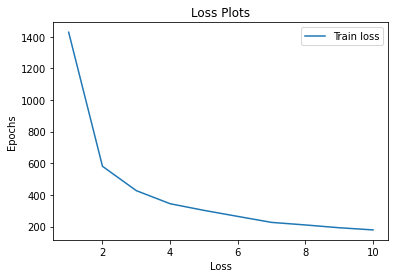

In [ ]:
fig=plt.figure()
plt.plot(np.arange(1, epochs+1), train_loss, label="Train loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

Now, test the accuracy of the model on the test set.

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for itr, (image, label) in enumerate(testloader):
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(label.reshape(len(label),)).sum() 
        total += float(len(label))
    accuracy = correct / total
    print(f'Accuracy of Neural Network is {accuracy:.4f}')

Accuracy of Neural Network is 0.9739


## Exercise 3:
Compare the accuracy of your feed-forward model from Deep Learning 1. Which one is higher? Could you give some reasons why? 

*HINT: what regularization do we use? what are some features of CNN?*

Answer: 

## Exercise 4:
1. Add a dropout layer to your CNN5 from exercise in the following code snippet. You do not need to change the structure. 

*HINT: Just one line of code.*
2. Train your final model
3. Draw out the loss

In [ ]:
# TODO 3.1
class CNN7(torch.nn.Module):
    def __init__(self):
        super(CNN7, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = torch.nn.ReLU()
        # TODO: add the second convolutional layer, maxpooling layer and dense layers

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.max_pool2d(x)
        # TODO
        pass

In [ ]:
# TODO 3.2

In [ ]:
# TODO 3.3

A possible solution to 3.1

In [ ]:
class CNN_example(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        return x

Reference:
* Towards data science: https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9
* Neuromatch Academy
* Graphs from  https://d2l.ai/ 